## Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import datetime as dt
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization


In [2]:
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)


## Load Data


In [3]:
high_altitude = pd.read_csv("./data/measurements-high-altitude.csv")
low_altitude = pd.read_csv("./data/measurements-low-altitude.csv")


## Data cleanup


In [4]:
list(high_altitude)


['hour',
 ' minute',
 ' second',
 ' azimuth angle (relative to west=0)/degree',
 ' elevation angle/degree',
 ' power/mW']

In [5]:
high_altitude.rename(columns={" power/mW": "power", " azimuth angle (relative to west=0)/degree": "azimuth", " elevation angle/degree": "elevation"}, inplace=True)
high_altitude.columns = high_altitude.columns.str.replace(" ", "")

low_altitude.rename(columns={" power/mW": "power", " azimuth angle (relative to west=0)/degree": "azimuth", " elevation angle/degree": "elevation"}, inplace=True)
low_altitude.columns = low_altitude.columns.str.replace(" ", "")


In [6]:
high_altitude.head()


,hour,minute,second,azimuth,elevation,power
0,9,45,5,0,0,32
1,9,45,9,0,15,879
2,9,45,12,0,30,34
3,9,45,15,0,45,35
4,9,45,18,0,60,51


In [7]:
low_altitude.head()


,hour,minute,second,azimuth,elevation,power
0,10,38,3,0,0,56
1,10,38,7,0,15,57
2,10,38,10,0,30,59
3,10,38,14,0,45,57
4,10,38,16,0,60,83


In [8]:
high_altitude.describe()


,hour,minute,second,azimuth,elevation,power
count,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000
mean,11.735925,29.474281,29.589307,89.467801,45.006075,231.443904
std,1.498760,17.265160,17.289971,57.050976,30.037962,175.365305
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,15.000000,15.000000,36.000000,15.000000,129.000000
50%,12.000000,30.000000,30.000000,90.000000,45.000000,217.000000
75%,13.000000,45.000000,45.000000,144.000000,75.000000,333.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,4168.000000


In [9]:
high_altitude.loc[high_altitude.power.idxmax(), :]


hour            9
minute         45
second         38
azimuth        18
elevation      45
power        4168
Name: 10, dtype: int64

In [10]:
low_altitude.describe()


,hour,minute,second,azimuth,elevation,power
count,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000
mean,11.880294,30.643139,29.224732,90.000000,45.000000,279.383399
std,1.090955,18.001482,17.335092,56.937075,30.008473,82.632597
min,10.000000,0.000000,0.000000,0.000000,0.000000,41.000000
25%,11.000000,14.000000,14.000000,36.000000,15.000000,225.000000
50%,12.000000,32.000000,29.000000,90.000000,45.000000,302.000000
75%,13.000000,47.000000,44.000000,144.000000,75.000000,352.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,378.000000


### Convert index in datetime


In [11]:
df = high_altitude.loc[:, ["hour", "minute", "second"]]
l = len(high_altitude)
df["year"] = [2016] * l
df["month"] = [11] * l
df["day"] = [23] * l

high_altitude = high_altitude.set_index(pd.to_datetime(df))
high_altitude.head()


,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:09,9,45,9,0,15,879
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51


In [12]:
df = low_altitude.loc[:, ["hour", "minute", "second"]]
l = len(low_altitude)
df["year"] = [2016] * l
df["month"] = [11] * l
df["day"] = [23] * l

low_altitude = low_altitude.set_index(pd.to_datetime(df))
low_altitude.head()


,hour,minute,second,azimuth,elevation,power
2016-11-23 10:38:03,10,38,3,0,0,56
2016-11-23 10:38:07,10,38,7,0,15,57
2016-11-23 10:38:10,10,38,10,0,30,59
2016-11-23 10:38:14,10,38,14,0,45,57
2016-11-23 10:38:16,10,38,16,0,60,83


### Remove outliers from high_altitude


In [13]:
print(high_altitude.shape)
high_altitude = high_altitude[(np.abs(stats.zscore(high_altitude)) < 3).all(axis=1)]
print(high_altitude.shape)
high_altitude


(2469, 6)
(2459, 6)


,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51
2016-11-23 09:45:21,9,45,21,0,75,76
...,...,...,...,...,...,...
2016-11-23 14:46:27,14,46,27,36,90,172
2016-11-23 14:46:30,14,46,30,54,0,108
2016-11-23 14:46:35,14,46,35,54,15,159
2016-11-23 14:46:38,14,46,38,54,30,213


### Plots


<AxesSubplot:title={'center':'High Altitude Peak Power Measurements'}>

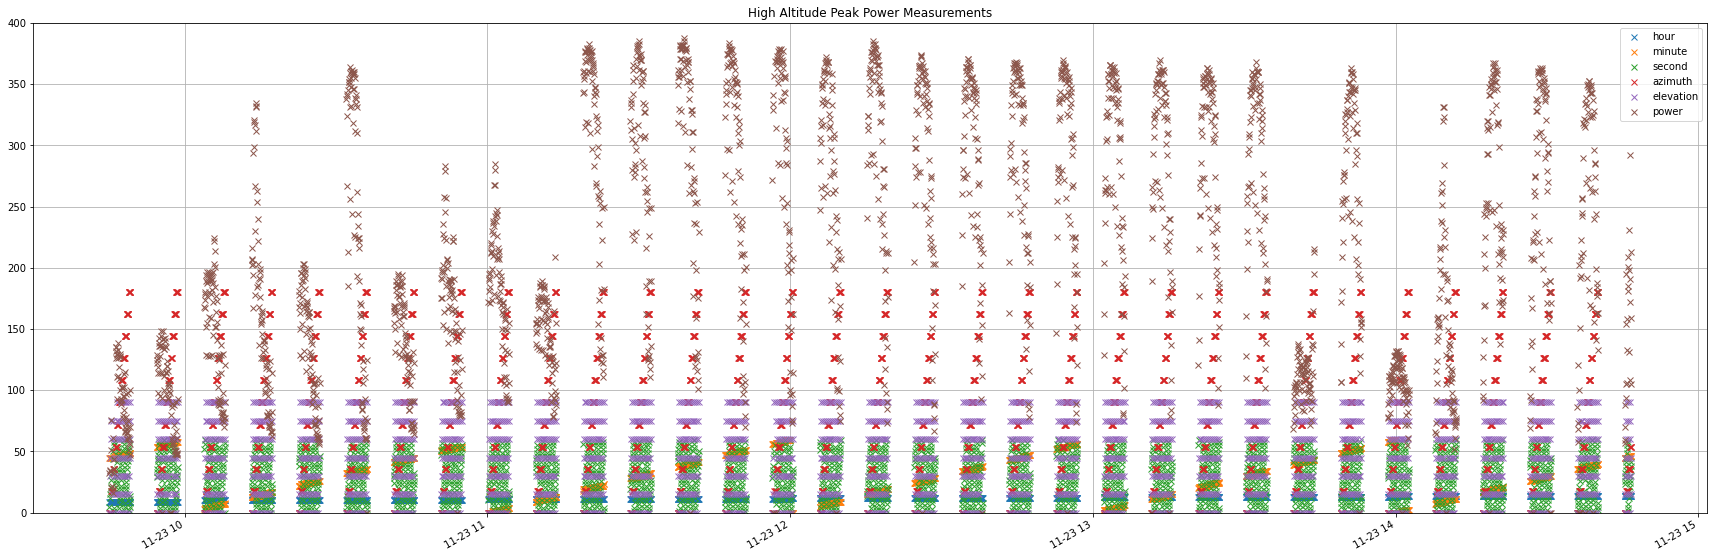

In [14]:
high_altitude.plot(figsize=(30, 10), title="High Altitude Peak Power Measurements", grid=True, marker="x", markersize=6, linestyle="None", ylim=(0, 400))


<AxesSubplot:title={'center':'Low Altitude Peak Power Measurements'}>

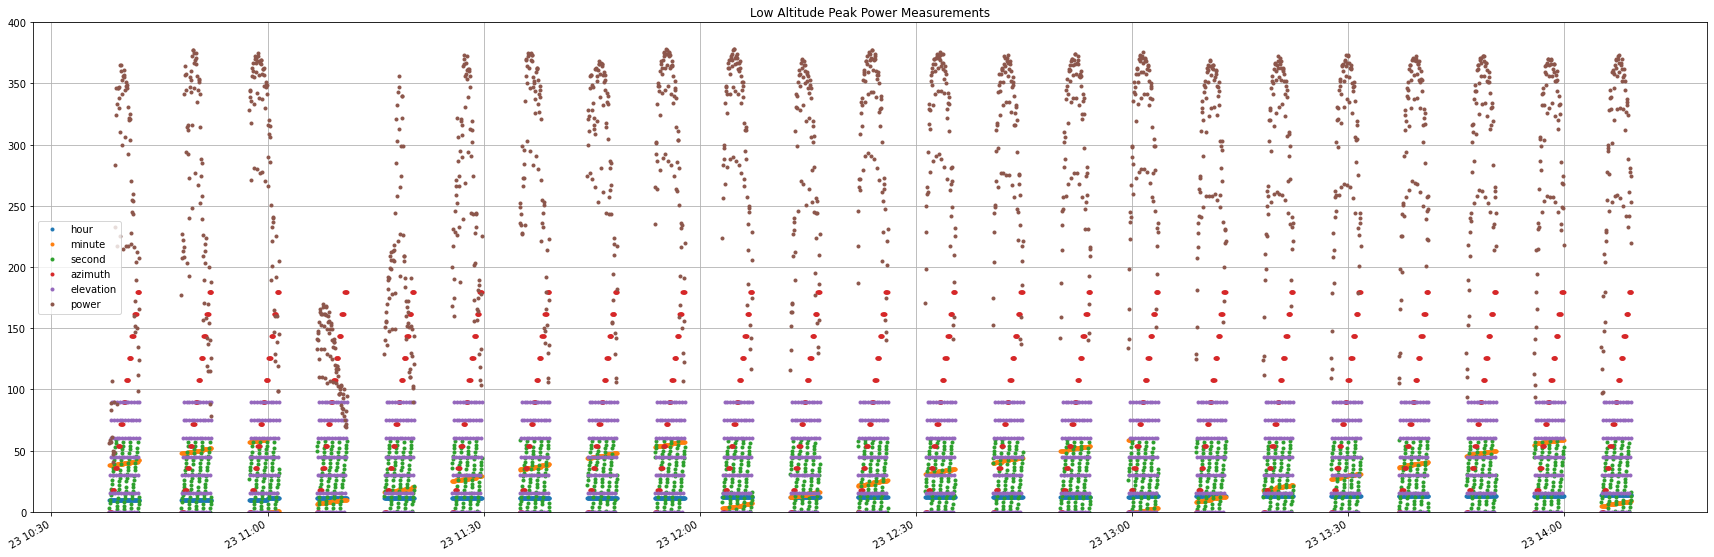

In [15]:
low_altitude.plot(figsize=(30, 10), title="Low Altitude Peak Power Measurements", grid=True, marker=".", markersize=6, linestyle="None", ylim=(0, 400))


## Regression using MLP


## Train test split


In [16]:
X_low_train = low_altitude.sample(frac=0.8, random_state=2)
X_low_test = low_altitude.drop(X_low_train.index)

y_low_train = X_low_train.pop("power")
y_low_test = X_low_test.pop("power")

print(y_low_train.describe())


count    1417.000000
mean      279.540579
std        82.386542
min        49.000000
25%       227.000000
50%       301.000000
75%       351.000000
max       378.000000
Name: power, dtype: float64


In [17]:
X_high_train = high_altitude.sample(frac=0.8, random_state=2)
X_high_test = high_altitude.drop(X_high_train.index)

y_high_train = X_high_train.pop("power")
y_high_test = X_high_test.pop("power")

print(y_high_train.describe())


count    1967.000000
mean      224.564311
std       104.227067
min         0.000000
25%       129.000000
50%       216.000000
75%       333.000000
max       388.000000
Name: power, dtype: float64


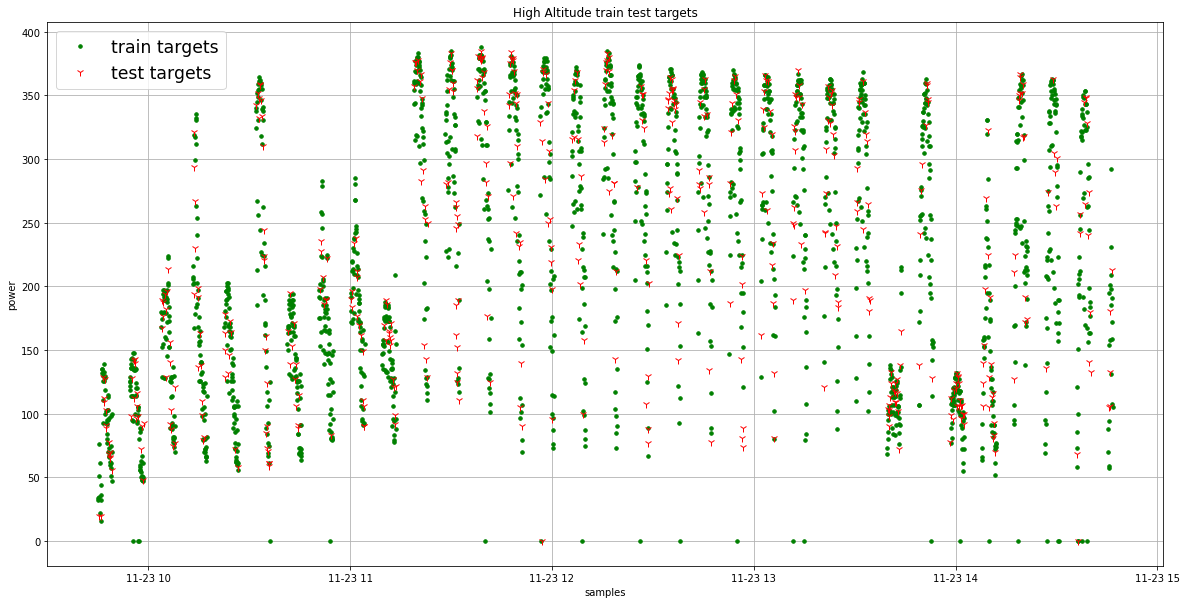

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(y_high_train, marker=".", color="g", linestyle="None", markersize=7, label="train targets")
plt.plot(y_high_test, marker="1", color="r", linestyle="None", markersize=7, label="test targets")
plt.title("High Altitude train test targets")
plt.xlabel("samples")
plt.ylabel("power")
plt.legend(fontsize="xx-large")
plt.grid()


### Normalization


In [19]:
normalizer_low = Normalization(axis=-1)
normalizer_low.adapt(np.array(X_low_train))

print("Normalizer low mean:", normalizer_low.mean.numpy())


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-19 11:35:43.036188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-19 11:35:43.036549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-19 11:35:43.076264: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-19 11:35:43.134058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 11:35:43.147254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Normalizer low mean: [[11.871558 30.616798 29.044462 88.81864  45.719826]]


In [20]:
first_sample = np.array(X_low_train[:1])

with np.printoptions(precision=2, suppress=True):
    print("X_low_train first sample:", np.sort(first_sample))
    print("X_low train first sample normalized:", np.sort(normalizer_low(first_sample).numpy()))


X_low_train first sample: [[ 0 11 15 26 44]]
X_low train first sample normalized: [[-1.56 -1.02 -0.8  -0.18  0.74]]


### Regressor


In [21]:
def create_regressor(normalizer):
    reg = Sequential(
        [
            normalizer,
            Dense(units=256, activation="relu"),
            Dropout(0.3),
            Dense(units=128, activation="relu"),
            Dense(units=1),
        ]
    )
    return reg


### Metrics


In [22]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-10, verbose=1), tf.keras.callbacks.EarlyStopping(patience=30)]
metrics = [tf.keras.metrics.MeanSquaredError()]


In [23]:
def plot_metrics(history, title: str = ""):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(20, 10)
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_title("loss (MAE)")
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("error")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history["mean_squared_error"], label="mse")
    ax2.plot(history.history["val_mean_squared_error"], label="val_mse")
    ax2.set_title("metric (MSE)")
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("error")
    ax2.legend()
    ax2.grid(True)


### Regression on Low Altitude


In [24]:
reg_low = create_regressor(normalizer_low)
reg_low.summary()
reg_low.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mae", metrics=metrics)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1536      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,572
Trainable params: 34,561
Non-trainable params: 11
___________________________________________________

In [25]:
history = reg_low.fit(X_low_train, y_low_train, epochs=1000, validation_split=0.2, callbacks=callbacks)


Epoch 1/1000
 1/36 [..............................] - ETA: 12s - loss: 282.9732 - mean_squared_error: 87789.7969

2022-07-19 11:35:43.750763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 10ms/step - loss: 110.7879 - mean_squared_error: 19505.8984 - val_loss: 74.3574 - val_mean_squared_error: 9708.9883 - lr: 0.1000
Epoch 2/1000
16/36 [============>.................] - ETA: 0s - loss: 85.8944 - mean_squared_error: 11325.4297

2022-07-19 11:35:44.195984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 8ms/step - loss: 82.6382 - mean_squared_error: 10461.1279 - val_loss: 90.2187 - val_mean_squared_error: 12224.1357 - lr: 0.1000
Epoch 3/1000
36/36 [==============================] - 0s 7ms/step - loss: 65.9545 - mean_squared_error: 6752.3184 - val_loss: 59.5856 - val_mean_squared_error: 5553.8813 - lr: 0.1000
Epoch 4/1000
36/36 [==============================] - 0s 8ms/step - loss: 53.9641 - mean_squared_error: 4751.6147 - val_loss: 41.6645 - val_mean_squared_error: 2580.4136 - lr: 0.1000
Epoch 5/1000
36/36 [==============================] - 0s 9ms/step - loss: 49.2235 - mean_squared_error: 3783.9880 - val_loss: 42.3451 - val_mean_squared_error: 2620.2769 - lr: 0.1000
Epoch 6/1000
36/36 [==============================] - 0s 7ms/step - loss: 43.8739 - mean_squared_error: 3139.4905 - val_loss: 44.5482 - val_mean_squared_error: 3379.1626 - lr: 0.1000
Epoch 7/1000
36/36 [==============================] - 0s 7ms/step - loss: 40.0098 - mean_squared

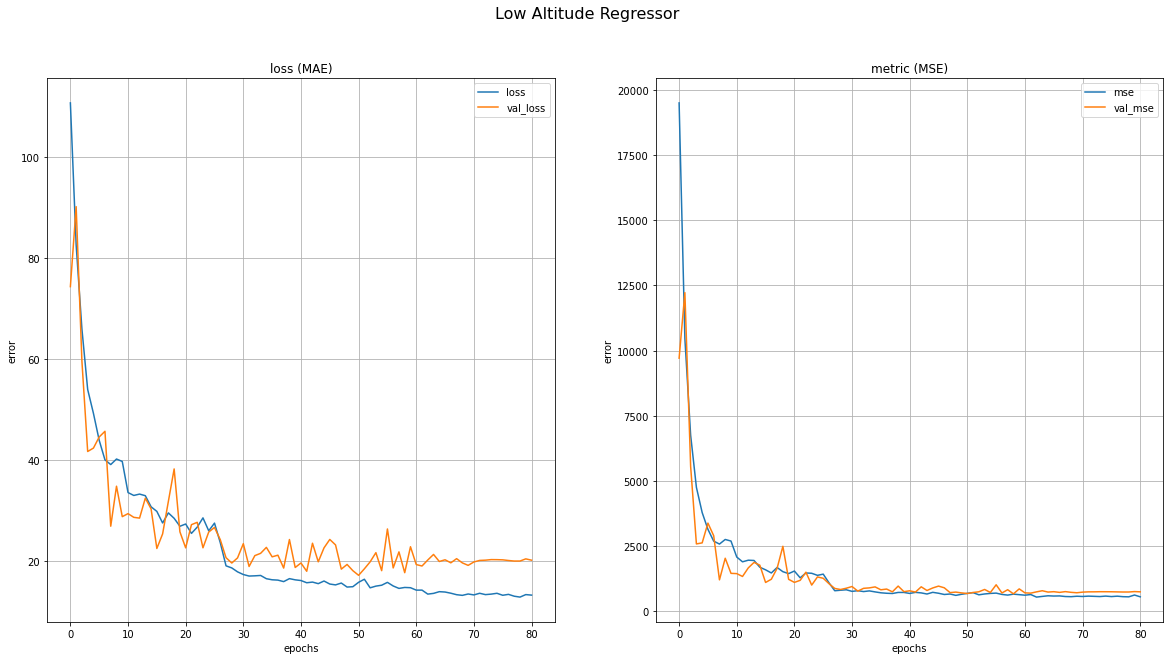

In [26]:
plot_metrics(history, title="Low Altitude Regressor")


In [27]:
results = reg_low.evaluate(X_low_test, y_low_test)

12/12 [==============================] - 0s 6ms/step - loss: 20.0712 - mean_squared_error: 759.2267


### Regression on High Altitude


In [28]:
normalizer_high = Normalization(axis=-1)
normalizer_high.adapt(np.array(X_high_train))

2022-07-19 11:36:05.193173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 11:36:05.205880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [29]:
first_sample = np.array(X_high_train[:1])

with np.printoptions(precision=2, suppress=True):
    print("X_low_train first sample:", np.sort(first_sample))
    print("X_low train first sample normalized:", np.sort(normalizer_high(first_sample).numpy()))


X_low_train first sample: [[ 11  15  40  50 144]]
X_low train first sample normalized: [[-1.01 -0.5   0.61  0.96  1.17]]


In [30]:
reg_high = create_regressor(normalizer_high)
reg_high.summary()
reg_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mae", metrics=metrics)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 256)               1536      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,572
Trainable params: 34,561
Non-trainable params: 11
_________________________________________________

In [31]:
history = reg_high.fit(X_high_train, y_high_train, epochs=1000, validation_split=0.2, callbacks=callbacks)


Epoch 1/1000
19/50 [==========>...................] - ETA: 0s - loss: 115.6107 - mean_squared_error: 14414.0566

2022-07-19 11:36:05.591423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 9ms/step - loss: 97.0787 - mean_squared_error: 13036.1279 - val_loss: 84.1406 - val_mean_squared_error: 11146.2627 - lr: 0.1000
Epoch 2/1000
19/50 [==========>...................] - ETA: 0s - loss: 82.4342 - mean_squared_error: 11013.2832

2022-07-19 11:36:06.031660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 0s 7ms/step - loss: 72.2634 - mean_squared_error: 8692.6270 - val_loss: 54.0079 - val_mean_squared_error: 5308.0410 - lr: 0.1000
Epoch 3/1000
50/50 [==============================] - 0s 7ms/step - loss: 61.7440 - mean_squared_error: 6568.0640 - val_loss: 50.8986 - val_mean_squared_error: 4233.2129 - lr: 0.1000
Epoch 4/1000
50/50 [==============================] - 0s 7ms/step - loss: 56.5053 - mean_squared_error: 5972.7661 - val_loss: 50.2885 - val_mean_squared_error: 4203.3647 - lr: 0.1000
Epoch 5/1000
50/50 [==============================] - 0s 7ms/step - loss: 54.2875 - mean_squared_error: 5458.3770 - val_loss: 111.7907 - val_mean_squared_error: 18008.7559 - lr: 0.1000
Epoch 6/1000
50/50 [==============================] - 0s 7ms/step - loss: 68.8885 - mean_squared_error: 7979.9839 - val_loss: 44.5702 - val_mean_squared_error: 4130.4614 - lr: 0.1000
Epoch 7/1000
50/50 [==============================] - 0s 8ms/step - loss: 50.2919 - mean_squared

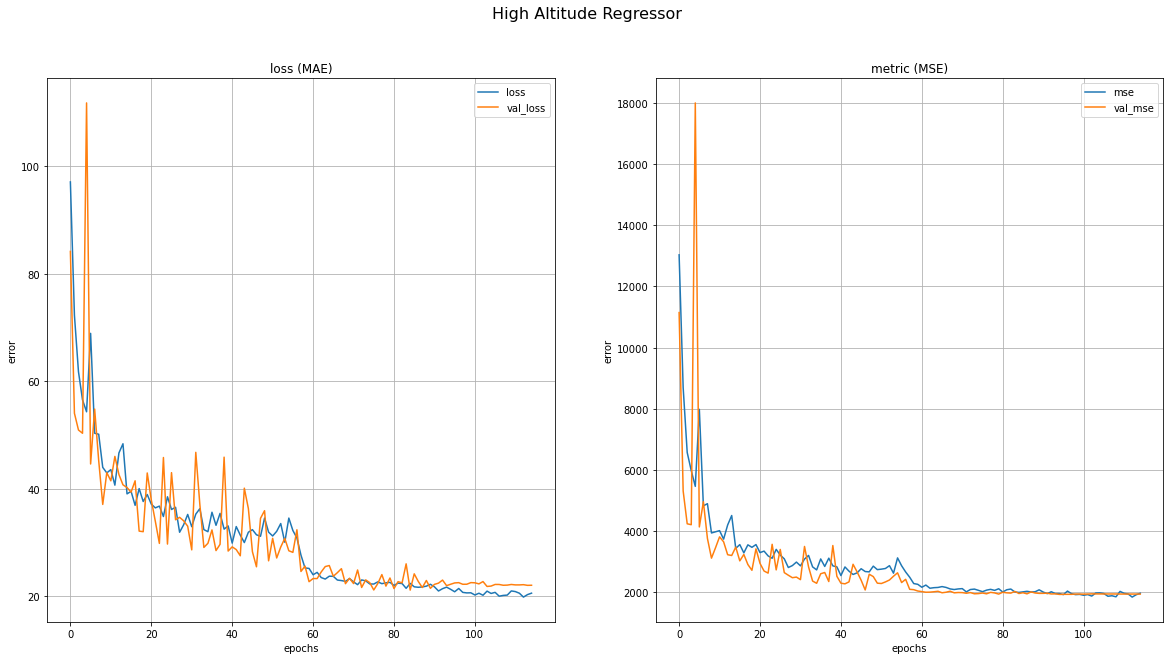

In [32]:
plot_metrics(history, title="High Altitude Regressor")


In [33]:
results = reg_high.evaluate(X_high_test, y_high_test)


16/16 [==============================] - 0s 5ms/step - loss: 21.7977 - mean_squared_error: 1916.5277


## Timeseries Forecasting


✅ Split dataset in multivariate time series

✅ Trained LSTM

Forecast LSTM predictions untill 20:00

- Manually create time, azimuth and elevation vectors for hour range 14:40 - 20:00
- Use LSTM to predict power given the manually created features


<AxesSubplot:title={'center':'High altitude'}>

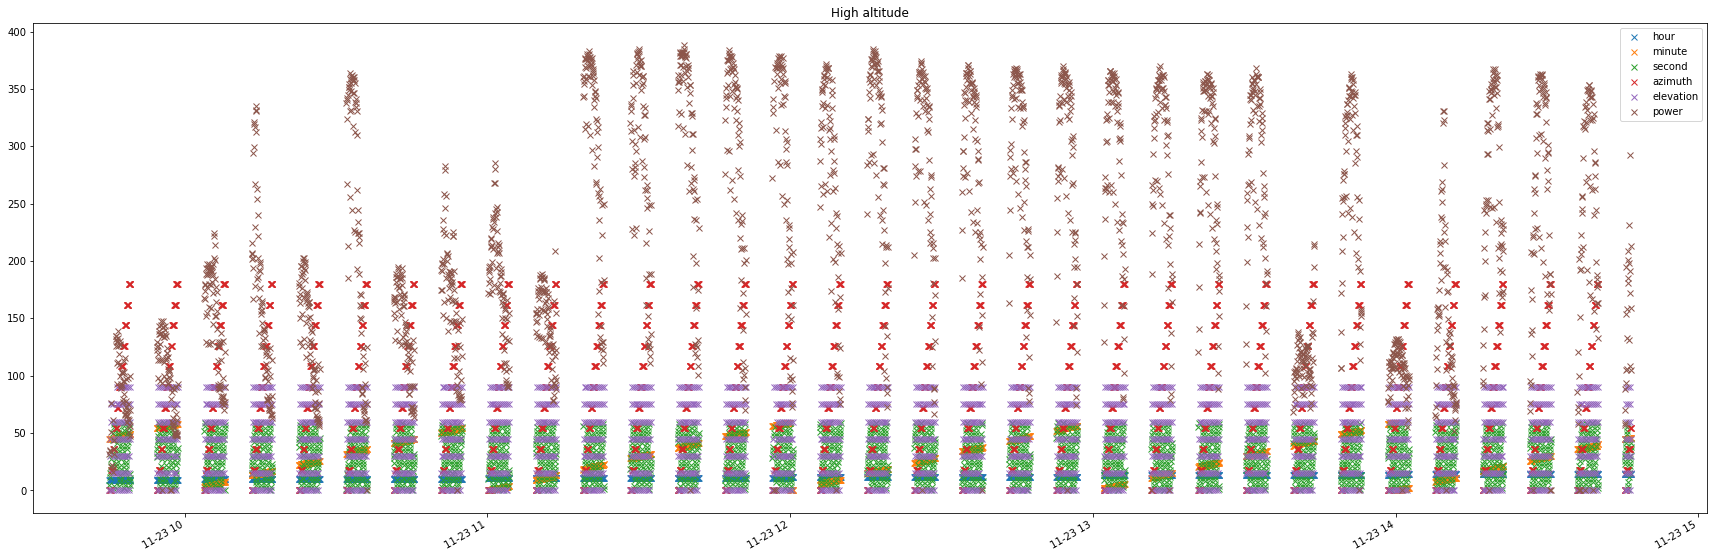

In [34]:
high_altitude.plot(figsize=(30, 10), title="High altitude", marker="x", linestyle="None")

### Utility functions


In [35]:
def normalize(df):
    df_std = df.copy()
    for column in df_std.columns[:-1]:
        df_std[column] = df_std[column] / df_std[column].max()
    return df_std


In [36]:
def plot_predictions(model, X, y):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={"Predictions": predictions, "Ground Truth": y})
    df.plot(figsize=(20, 10), marker="x", linestyle="--", xlabel="samples", ylabel="power", title="Predictions vs Actuals")
    return df


In [37]:
def df_to_X_y(df, window_size=5, horizon=1):
    df_as_np = df.to_numpy()
    X = []
    y = []
    if (len(df_as_np) - window_size - horizon) == 0:
        row = [r for r in df_as_np[:window_size, :]]
        X.append(row)
        label = df_as_np[horizon + window_size][-1]
        y.append(label)
        return np.array(X), np.array(y)
    for i in range(len(df_as_np) - window_size - horizon):
        row = [r for r in df_as_np[i : i + window_size, :]]
        X.append(row)
        label = df_as_np[i + horizon + window_size][-1]
        y.append(label)
    return np.array(X), np.array(y)


In [38]:
def df_to_X(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    if (len(df_as_np) - window_size) == 0:
        row = [r for r in df_as_np[:window_size, :]]
        X.append(row)
        return np.array(X)

    for i in range(len(df_as_np) - window_size - 1):
        row = [r for r in df_as_np[i : i + window_size, :]]
        X.append(row)
    return np.array(X)


## Forecast on high_altitude_norm_correct


### Generate times, elevation and azimuth vectors to predict power for the rest of the day


In [39]:
future_azimuth = []
future_elevation = []
current_time = high_altitude.index.values
current_time_last = current_time[-1]

# create a vector of dates from current_time_last to the hours 20:00 of the same day with a frequency of 5 seconds
future_time = pd.date_range(current_time_last, end="2016-11-23T20:00:00", freq="5S")

# extending the azimuth vector
curr_azimuth = high_altitude["azimuth"]
period = np.unique(curr_azimuth[2361:2434])
to_repeat = []
for elem in period:
    to_repeat += [elem] * 7

future_azimuth = np.tile(to_repeat, len(future_time) // len(to_repeat))

future_df = pd.DataFrame({"azimuth": future_azimuth})

future_time = future_time[: len(future_azimuth)]

len(future_time)
future_df.index = future_time

# extending the elevation vector
curr_elevation = high_altitude["elevation"]
elevation_period = [0, 15, 30, 45, 60, 75, 90]
future_elevation = elevation_period * (future_df.shape[0] // len(elevation_period))
future_df["elevation"] = future_elevation

# adding time as features in the dataset
future_df["hour"] = future_df.index.hour
future_df["minute"] = future_df.index.minute
future_df["second"] = future_df.index.second
future_df = future_df[["hour", "minute", "second", "azimuth", "elevation"]]

print(future_df)


                     hour  minute  second  azimuth  elevation
2016-11-23 14:46:41    14      46      41        0          0
2016-11-23 14:46:46    14      46      46        0         15
2016-11-23 14:46:51    14      46      51        0         30
2016-11-23 14:46:56    14      46      56        0         45
2016-11-23 14:47:01    14      47       1        0         60
...                   ...     ...     ...      ...        ...
2016-11-23 19:54:16    19      54      16      180         30
2016-11-23 19:54:21    19      54      21      180         45
2016-11-23 19:54:26    19      54      26      180         60
2016-11-23 19:54:31    19      54      31      180         75
2016-11-23 19:54:36    19      54      36      180         90

[3696 rows x 5 columns]


### Normalizing high_altitude based on full day time


In [40]:
final_df = pd.concat([high_altitude, future_df], axis=0)
print(final_df)
final_df_norm = normalize(final_df)
print(final_df_norm)


                     hour  minute  second  azimuth  elevation  power
2016-11-23 09:45:05     9      45       5        0          0   32.0
2016-11-23 09:45:12     9      45      12        0         30   34.0
2016-11-23 09:45:15     9      45      15        0         45   35.0
2016-11-23 09:45:18     9      45      18        0         60   51.0
2016-11-23 09:45:21     9      45      21        0         75   76.0
...                   ...     ...     ...      ...        ...    ...
2016-11-23 19:54:16    19      54      16      180         30    NaN
2016-11-23 19:54:21    19      54      21      180         45    NaN
2016-11-23 19:54:26    19      54      26      180         60    NaN
2016-11-23 19:54:31    19      54      31      180         75    NaN
2016-11-23 19:54:36    19      54      36      180         90    NaN

[6155 rows x 6 columns]
                         hour    minute    second  azimuth  elevation  power
2016-11-23 09:45:05  0.473684  0.762712  0.084746      0.0   0.000000 

In [41]:
high_altitude_norm_correct = final_df_norm.iloc[: high_altitude.shape[0], :]
# high_altitude_norm_correct.to_csv("high_altitude_norm_correct.csv")
print(high_altitude_norm_correct)


                         hour    minute    second  azimuth  elevation  power
2016-11-23 09:45:05  0.473684  0.762712  0.084746      0.0   0.000000   32.0
2016-11-23 09:45:12  0.473684  0.762712  0.203390      0.0   0.333333   34.0
2016-11-23 09:45:15  0.473684  0.762712  0.254237      0.0   0.500000   35.0
2016-11-23 09:45:18  0.473684  0.762712  0.305085      0.0   0.666667   51.0
2016-11-23 09:45:21  0.473684  0.762712  0.355932      0.0   0.833333   76.0
...                       ...       ...       ...      ...        ...    ...
2016-11-23 14:46:27  0.736842  0.779661  0.457627      0.2   1.000000  172.0
2016-11-23 14:46:30  0.736842  0.779661  0.508475      0.3   0.000000  108.0
2016-11-23 14:46:35  0.736842  0.779661  0.593220      0.3   0.166667  159.0
2016-11-23 14:46:38  0.736842  0.779661  0.644068      0.3   0.333333  213.0
2016-11-23 14:46:41  0.736842  0.779661  0.694915      0.3   0.500000  105.0

[2459 rows x 6 columns]


## Train the forecasting LSTM network


### Train test split


In [42]:
X, y = df_to_X_y(high_altitude_norm_correct)

df_len = high_altitude_norm_correct.shape[0]
train = int(df_len * 0.7)
val = int(df_len * 0.9)
X_train, y_train = X[:train], y[:train]
X_val, y_val = X[train:val], y[train:val]
X_test, y_test = X[val:], y[val:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((1721, 5, 6), (1721,), (492, 5, 6), (492,), (240, 5, 6), (240,))

## Model


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((5, 6)))
model.add(LSTM(64))
model.add(Dense(8, "relu"))
model.add(Dense(1, "linear"))

model.summary()

model.compile(loss="mae", optimizer=Adam())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [44]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-10, verbose=1), tf.keras.callbacks.EarlyStopping(patience=50)]


In [45]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=callbacks)


Epoch 1/300


2022-07-19 11:36:49.978299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 11:36:50.150302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/54 [==>...........................] - ETA: 0s - loss: 223.1045 

2022-07-19 11:36:50.240613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 15ms/step - loss: 226.6979 - val_loss: 196.3825 - lr: 0.0010
Epoch 2/300
 1/54 [..............................] - ETA: 0s - loss: 187.9017

2022-07-19 11:36:50.972500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 11:36:51.036639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step - loss: 220.8414 - val_loss: 189.3972 - lr: 0.0010
Epoch 3/300
54/54 [==============================] - 1s 10ms/step - loss: 211.5510 - val_loss: 177.5116 - lr: 0.0010
Epoch 4/300
54/54 [==============================] - 1s 11ms/step - loss: 198.1023 - val_loss: 161.7929 - lr: 0.0010
Epoch 5/300
54/54 [==============================] - 1s 12ms/step - loss: 181.1331 - val_loss: 143.4527 - lr: 0.0010
Epoch 6/300
54/54 [==============================] - 1s 12ms/step - loss: 162.3017 - val_loss: 124.3026 - lr: 0.0010
Epoch 7/300
54/54 [==============================] - 1s 11ms/step - loss: 144.8746 - val_loss: 107.9570 - lr: 0.0010
Epoch 8/300
54/54 [==============================] - 1s 10ms/step - loss: 130.0540 - val_loss: 97.0716 - lr: 0.0010
Epoch 9/300
54/54 [==============================] - 1s 11ms/step - loss: 117.6694 - val_loss: 92.2594 - lr: 0.0010
Epoch 10/300
54/54 [==============================] - 1s 10ms/step - loss: 108

2022-07-19 11:39:27.895069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 11:39:28.010724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


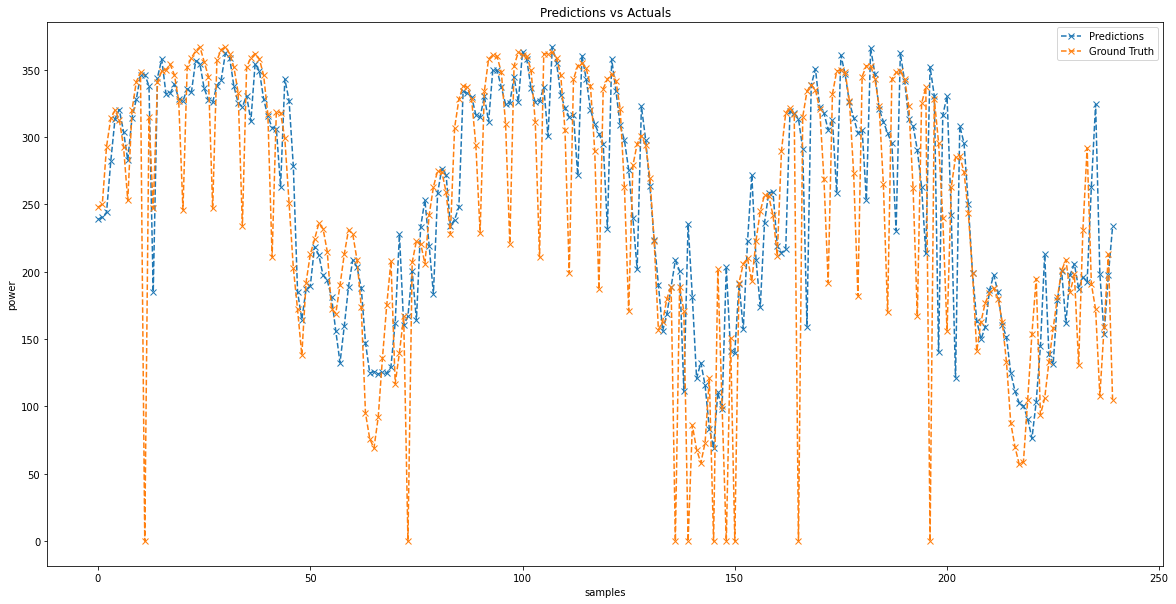

In [46]:
test_predictions = plot_predictions(model, X_test, y_test)


In [47]:
print(test_predictions["Predictions"].mean())
print(test_predictions["Ground Truth"].mean())
print(test_predictions["Predictions"].mean() - test_predictions["Ground Truth"].mean())


254.04637
245.27083333333334
8.775538126627595


In [48]:
# model.save("./forecasting_model/forecast_lstm_norm.h5")


In [49]:
last_ground_truth = high_altitude_norm_correct.iloc[-5:, :]
last_ground_truth


,hour,minute,second,azimuth,elevation,power
2016-11-23 14:46:27,0.736842,0.779661,0.457627,0.2,1.000000,172.0
2016-11-23 14:46:30,0.736842,0.779661,0.508475,0.3,0.000000,108.0
2016-11-23 14:46:35,0.736842,0.779661,0.593220,0.3,0.166667,159.0
2016-11-23 14:46:38,0.736842,0.779661,0.644068,0.3,0.333333,213.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.3,0.500000,105.0


### Testing the model for forecasting


In [50]:
trial_x = df_to_X(last_ground_truth)


In [51]:
trial_x


array([[[7.36842105e-01, 7.79661017e-01, 4.57627119e-01, 2.00000000e-01,
         1.00000000e+00, 1.72000000e+02],
        [7.36842105e-01, 7.79661017e-01, 5.08474576e-01, 3.00000000e-01,
         0.00000000e+00, 1.08000000e+02],
        [7.36842105e-01, 7.79661017e-01, 5.93220339e-01, 3.00000000e-01,
         1.66666667e-01, 1.59000000e+02],
        [7.36842105e-01, 7.79661017e-01, 6.44067797e-01, 3.00000000e-01,
         3.33333333e-01, 2.13000000e+02],
        [7.36842105e-01, 7.79661017e-01, 6.94915254e-01, 3.00000000e-01,
         5.00000000e-01, 1.05000000e+02]]])

### Assembling the dataframe on which to forecast power values


In [52]:
model = tf.keras.models.load_model("./forecasting_model/forecast_lstm_norm_correct.h5")


In [53]:
final_df = pd.concat([last_ground_truth, final_df_norm[high_altitude.shape[0] :]], axis=0)
final_df.head(20)


,hour,minute,second,azimuth,elevation,power
2016-11-23 14:46:27,0.736842,0.779661,0.457627,0.2,1.000000,172.0
2016-11-23 14:46:30,0.736842,0.779661,0.508475,0.3,0.000000,108.0
2016-11-23 14:46:35,0.736842,0.779661,0.593220,0.3,0.166667,159.0
2016-11-23 14:46:38,0.736842,0.779661,0.644068,0.3,0.333333,213.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.3,0.500000,105.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.0,0.000000,NaN
2016-11-23 14:46:46,0.736842,0.779661,0.779661,0.0,0.166667,NaN
2016-11-23 14:46:51,0.736842,0.779661,0.864407,0.0,0.333333,NaN
2016-11-23 14:46:56,0.736842,0.779661,0.949153,0.0,0.500000,NaN
2016-11-23 14:47:01,0.736842,0.796610,0.016949,0.0,0.666667,NaN


In [54]:
# final_df.to_csv("final_df_for_forecasting.csv")


In [55]:
final_df = pd.read_csv("final_df_for_forecasting.csv", index_col=0)
final_df


,hour,minute,second,azimuth,elevation,power
2016-11-23 14:46:27,0.736842,0.779661,0.457627,0.2,1.000000,172.0
2016-11-23 14:46:30,0.736842,0.779661,0.508475,0.3,0.000000,108.0
2016-11-23 14:46:35,0.736842,0.779661,0.593220,0.3,0.166667,159.0
2016-11-23 14:46:38,0.736842,0.779661,0.644068,0.3,0.333333,213.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.3,0.500000,105.0
...,...,...,...,...,...,...
2016-11-23 19:54:16,1.000000,0.915254,0.271186,1.0,0.333333,NaN
2016-11-23 19:54:21,1.000000,0.915254,0.355932,1.0,0.500000,NaN
2016-11-23 19:54:26,1.000000,0.915254,0.440678,1.0,0.666667,NaN
2016-11-23 19:54:31,1.000000,0.915254,0.525424,1.0,0.833333,NaN


### Forecasting power values


In [56]:
def forecast(df, model, window_size=5):
    forecasted_df = df.copy()
    for i in range(len(forecasted_df) - window_size):
        window = np.expand_dims(forecasted_df.iloc[i : i + window_size, :].to_numpy(), axis=0)
        # print(window)
        pred = int(model.predict(window)[0][0])
        forecasted_df.iat[i + window_size, 5] = pred
    return forecasted_df


In [57]:
forecasted_df = forecast(final_df, model)
forecasted_df


2022-07-19 11:39:29.157653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-19 11:39:29.221801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,hour,minute,second,azimuth,elevation,power
2016-11-23 14:46:27,0.736842,0.779661,0.457627,0.2,1.000000,172.0
2016-11-23 14:46:30,0.736842,0.779661,0.508475,0.3,0.000000,108.0
2016-11-23 14:46:35,0.736842,0.779661,0.593220,0.3,0.166667,159.0
2016-11-23 14:46:38,0.736842,0.779661,0.644068,0.3,0.333333,213.0
2016-11-23 14:46:41,0.736842,0.779661,0.694915,0.3,0.500000,105.0
...,...,...,...,...,...,...
2016-11-23 19:54:16,1.000000,0.915254,0.271186,1.0,0.333333,222.0
2016-11-23 19:54:21,1.000000,0.915254,0.355932,1.0,0.500000,291.0
2016-11-23 19:54:26,1.000000,0.915254,0.440678,1.0,0.666667,300.0
2016-11-23 19:54:31,1.000000,0.915254,0.525424,1.0,0.833333,272.0


<AxesSubplot:>

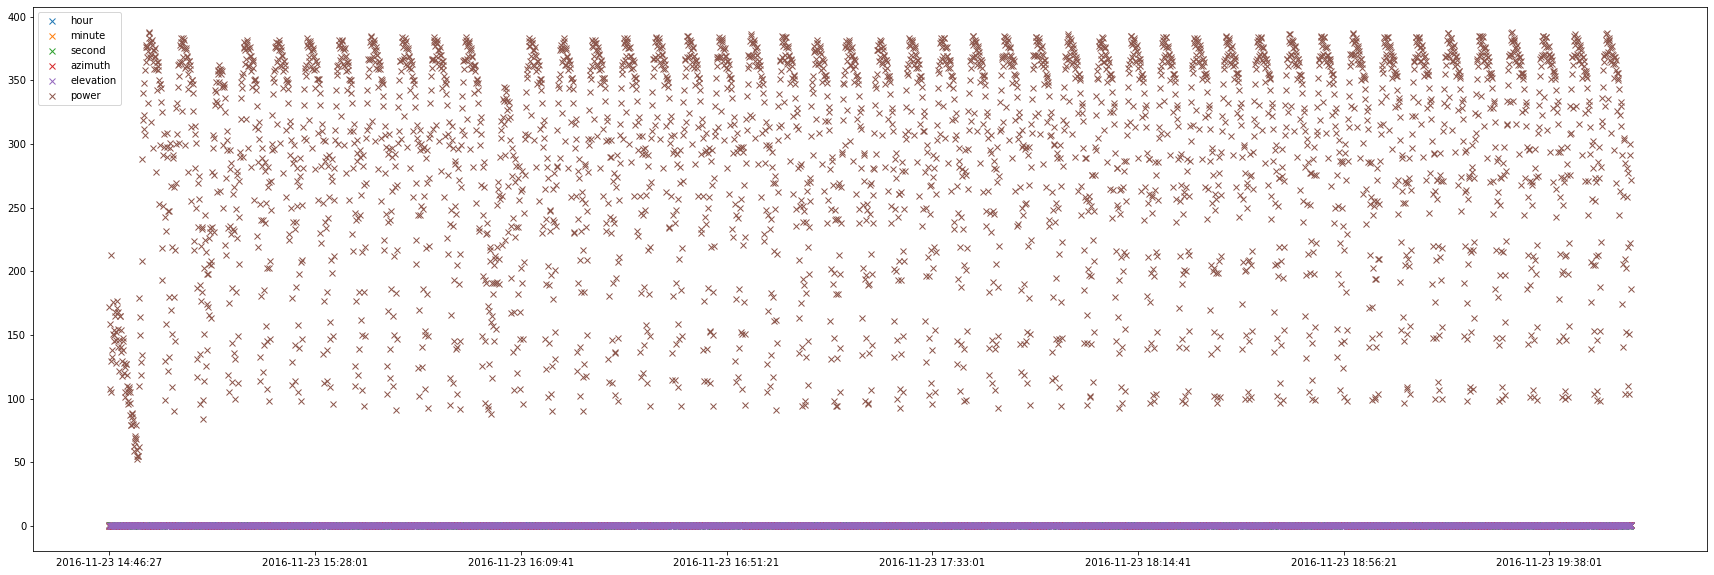

In [58]:
forecasted_df.plot(figsize=(30, 10), marker="x", linewidth=0.5, linestyle="None")


### Assembling the final dataframe containing the original values and the forecasted values for the rest of the day


In [59]:
high_altitude_whole_day = pd.concat([high_altitude_norm_correct, forecasted_df], axis=0)
# high_altitude_whole_day.to_csv("datasets/high_altitude_whole_day.csv")
high_altitude_whole_day


,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,0.473684,0.762712,0.084746,0.0,0.000000,32.0
2016-11-23 09:45:12,0.473684,0.762712,0.203390,0.0,0.333333,34.0
2016-11-23 09:45:15,0.473684,0.762712,0.254237,0.0,0.500000,35.0
2016-11-23 09:45:18,0.473684,0.762712,0.305085,0.0,0.666667,51.0
2016-11-23 09:45:21,0.473684,0.762712,0.355932,0.0,0.833333,76.0
...,...,...,...,...,...,...
2016-11-23 19:54:16,1.000000,0.915254,0.271186,1.0,0.333333,222.0
2016-11-23 19:54:21,1.000000,0.915254,0.355932,1.0,0.500000,291.0
2016-11-23 19:54:26,1.000000,0.915254,0.440678,1.0,0.666667,300.0
2016-11-23 19:54:31,1.000000,0.915254,0.525424,1.0,0.833333,272.0


<AxesSubplot:>

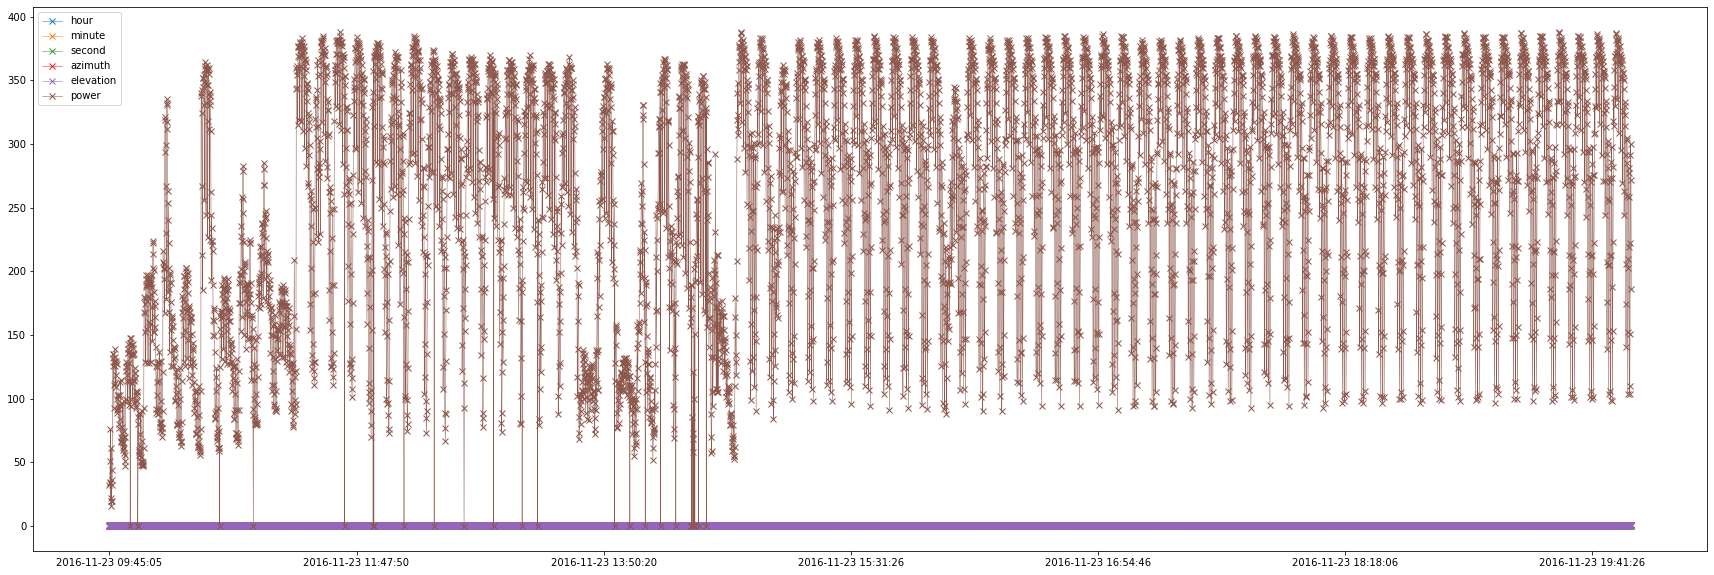

In [60]:
high_altitude_whole_day.plot(figsize=(30, 10), marker="x", linewidth=0.5)


To Do:

- calcolare il power generato in un giorno a partire da high_altitude_whole_day: usando la media?, la somma?
- trovare le dimensioni di un pannello solare
- trovare il fabbisogno energetico della carinzia
- misurare montagne carinzia su google earth (o solo monte Dobratsch)
- dividere area montagne per area pannello -> si ottiene quanti pannelli entrano sulle montagne
- calcolare il power generato in un giorno dal numero di pannelli che entrano sulle montagne
- verificare che sia sufficiente per soddisfare il fabbisogno della Carinzia (o della sola Klagenfurt)

- idea: fare una funzione che prende in input le dimensioni di un pannello, l'area disponibile, il power generato da un pannello e da


### Hourly power generation

- Calculate power peak for each second
- sum the calculated power peaks of each hour
- calculate the avg hourly power


In [216]:
high_altitude_whole_day.index=pd.to_datetime(high_altitude_whole_day.index)
high_altitude_whole_day

,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,0.473684,0.762712,0.084746,0.0,0.000000,32.0
2016-11-23 09:45:12,0.473684,0.762712,0.203390,0.0,0.333333,34.0
2016-11-23 09:45:15,0.473684,0.762712,0.254237,0.0,0.500000,35.0
2016-11-23 09:45:18,0.473684,0.762712,0.305085,0.0,0.666667,51.0
2016-11-23 09:45:21,0.473684,0.762712,0.355932,0.0,0.833333,76.0
...,...,...,...,...,...,...
2016-11-23 19:54:16,1.000000,0.915254,0.271186,1.0,0.333333,222.0
2016-11-23 19:54:21,1.000000,0.915254,0.355932,1.0,0.500000,291.0
2016-11-23 19:54:26,1.000000,0.915254,0.440678,1.0,0.666667,300.0
2016-11-23 19:54:31,1.000000,0.915254,0.525424,1.0,0.833333,272.0


In [252]:
def hourly_power_generation(df):
    idx = df.index
    total_seconds = []
    hourly_means = []
    power_per_second = []
    hpg_hours = []
    hpg_power = []
    count=0
    for i in range(len(idx)-1):
        hour_curr = idx[i].hour
        hour_succ = idx[i + 1].hour
        hour_delta = hour_curr - hour_pred
        
        delta_timestamp = abs(idx[i] - idx[i + 1])

        delta_seconds = int(delta_timestamp.total_seconds())

        missing_power = [int(df['power'][i])] * delta_seconds
        power_per_second += missing_power


        if hour_curr != hour_succ:
            hpg_hours.append(f'{hour_curr} -> {hour_succ}')
            hpg_power.append(f'{sum(power_per_second) * 1e-3:.2f}')
            power_per_second = []
            # print('num samples: ',len(power_per_second))
            # print(f'{sum(power_per_second) * 1e-3:.2f} w/h')
            # print('\n')
    hpg_hours.append('19 -> 20')
    hpg_power.append(f'{sum(power_per_second) * 1e-3:.2f}')
    power_per_second = []
    return pd.DataFrame({'hour':hpg_hours, 'power (w/h)':hpg_power})


In [253]:
hpg = hourly_power_generation(high_altitude_whole_day)
hpg

,hour,power (w/h)
0,9 -> 10,103.33
1,10 -> 11,474.78
2,11 -> 12,828.60
3,12 -> 13,884.48
4,13 -> 14,742.75
5,14 -> 15,580.91
6,15 -> 16,1046.51
7,16 -> 17,1034.60
8,17 -> 18,1050.83
9,18 -> 19,1077.50


In [235]:
pv_panel_dims = (165, 99)
pv_panel_area = pv_panel_dims[0] * pv_panel_dims[1]
pv_panel_area = pv_panel_area * 0.0001
print(f'Typical residential photovoltaic panel area: {pv_panel_area:.2f} m^2')

Typical residential photovoltaic panel area: 1.63 m^2


In [433]:
def get_generated_power(total_area: float, one_panel_mean_hourly_power: float,  panel_dimensions: tuple[float, float] = (1.65, 0.99)) -> float:
  '''Calculates the average hourly power generated in a day by the number of panels that would fit in the specified area'''

  mountain_area = total_area * 1e6 #mountain_area should be in km^2. Here is converted in m^2
  n_fitting_panels = int(mountain_area / pv_panel_area)
  print(f'Number of panels that would fit on the Dobratsch selected area: {n_fitting_panels:,}\n')

  print(f'Mean hourly power generated by a single panel in a day: {one_panel_mean_hourly_power:,.2f} W/h\n')

  total_power = n_fitting_panels * one_panel_mean_hourly_power
  total_power *= 1e-3 #total_power should be in kW
  print(f'Hourly power generated by all the panels in Dobratsch combined: {total_power:,.2f} kW/h')
  return total_power

In [434]:
def get_n_panels_area(one_panel_mean_hourly_power: float, panel_dimensions: tuple[float, float], power_consumption: float)-> tuple[float, float]:
  
  n_panels_required = int(power_consumption / (one_panel_mean_hourly_power * 1e-3))
  area_required = n_panels_required * panel_dimensions[0] * panel_dimensions[1] * 1e-6
  print(f'Number of panels required to satisfy the power consumption: {n_panels_required:,}\n')
  print(f'Area required to satisfy the power consumption: {area_required:,.2f} km^2\n')
  return n_panels_required, area_required

### Dobratsch mountain reference area
Area: 0.93km^2 <br /><br />
![<caption>](img/dobratsch_area2.png)

### Panels that would fit on Dobratsch mountain and how much power they would generate

In [435]:
total_daily_power = get_generated_power(total_area=0.93, panel_dimensions = (1.65, 0.99), one_panel_mean_hourly_power=hpg['power (w/h)'].astype(float).mean())

Number of panels that would fit on the Dobratsch selected area: 569,329

Mean hourly power generated by a single panel in a day: 799.83 W/h

Hourly power generated by all the panels in Dobratsch combined: 455,365.38 kW/h


### Panels and area necessary to satisfy Carinthia's demand

In [436]:
carinthia_inhabitants = 560939 
power_consumption_per_person = 6.57 #kW/h
carinthia_power_consumption = carinthia_inhabitants * power_consumption_per_person #kW/h
print(f'carinthia_power_consumption: {carinthia_power_consumption:,} kW/h')

carinthia_power_consumption: 3,685,369.23 kW/h


In [437]:
n_panels_required, area_required = get_n_panels_area(one_panel_mean_hourly_power=hpg['power (w/h)'].astype(float).mean(), power_consumption= carinthia_power_consumption, panel_dimensions=(1.65, 0.99))

Number of panels required to satisfy the power consumption: 4,607,701

Area required to satisfy the power consumption: 7.53 km^2

